# Iris Dataset Using Pytorch

In [1]:
# importing the libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.utils.data as d
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
def argmax_func(tensor: torch.tensor):
    max_indices = torch.argmax(tensor, dim=1)
    binary_tensor = torch.zeros_like(tensor)
    binary_tensor[torch.arange(len(max_indices)), max_indices] = 1
    return binary_tensor

NameError: name 'torch' is not defined

In [2]:
# Load data
df_iris = load_iris()
X = pd.DataFrame(df_iris.data, columns=[df_iris.feature_names])
y = pd.Series(df_iris.target)

# prepara data
y = pd.get_dummies(y)

In [3]:
# transforms into vectors
X = X.values
y = y.values

In [4]:
# Split in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True, stratify=y, test_size=0.2)

# normalize data
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

In [5]:
# Transforms into torch tensor
X_train = torch.tensor(X_train, dtype=torch.float64)
X_test = torch.tensor(X_test, dtype=torch.float64)

y_train = torch.tensor(y_train, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)

In [6]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, shuffle=True, batch_size=12)
test_loader = DataLoader(test_data, batch_size=len(test_data.tensors[0]))

In [7]:
# building the model
class IrisNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(IrisNN, self).__init__()
        self.input = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.output = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.softmax(self.output(x), dim=-1)
        return x

In [8]:
# model parameters
INPUT_SIZE = 4
hidden_size = 4
NUM_CLASSES = 3
model = IrisNN(
    input_size=INPUT_SIZE,
    hidden_size=hidden_size,
    num_classes=NUM_CLASSES
)

In [9]:
# looking at the output of the model
model(train_data[0][0].float())

tensor([0.2752, 0.2575, 0.4673], grad_fn=<SoftmaxBackward0>)

In [10]:
# testing the working of the model
tensor = torch.randn(1, 4)
print('Tensor de entrada:')
print(tensor[0])
print('Tensor de saída:')
print(model(tensor))
print(f'A saída soma um: {model(tensor).sum()}')

Tensor de entrada:
tensor([-1.6045,  0.2177, -0.9930, -0.4926])
Tensor de saída:
tensor([[0.2625, 0.3209, 0.4166]], grad_fn=<SoftmaxBackward0>)
A saída soma um: 0.9999999403953552


In [11]:
EPOCHS = 100
learning_rate = 0.01 

In [12]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

In [14]:
# Valid training
train_accuracies, test_accuracies = [], []
loss_train = []
# training model

for epoch in range(EPOCHS):
    # Train set
    for X_train, y_train in train_loader:
        preds = model(X_train.float())
        pred_labels_train = argmax_func(preds)
        loss = loss_function(preds, y_train)
        loss_train.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        correct_rows_train = (y_train == pred_labels_train).all(dim=1)
        accuracy_train = correct_rows_train.float().mean().item()
    train_accuracies.append(accuracy_train)
    
    # Test set
    X_test, y_test = next(iter(test_loader))
    pred_labels_test = argmax_func(model(X_test.float()))
    correct_rows_test = (y_test == pred_labels_test).all(dim=1)
    accuracy_test = correct_rows_test.float().mean().item()
    test_accuracies.append(accuracy_test)

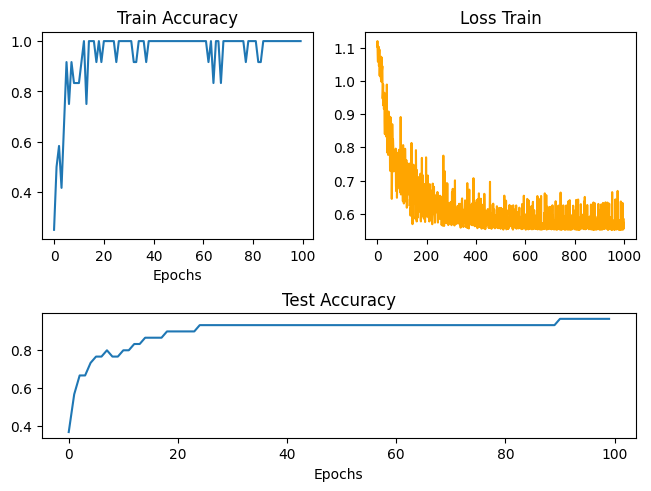

In [16]:
height_ratios = [5,3]
width_ratios = [1,1]
fig = plt.figure(constrained_layout=True)
ax_dict = fig.subplot_mosaic(
    "AB;CC", 
    height_ratios=height_ratios, 
    width_ratios=width_ratios
)
ax_dict['A'].plot(train_accuracies)
ax_dict['A'].set_title('Train Accuracy')
ax_dict['A'].set_xlabel('Epochs')
ax_dict['B'].plot(loss_train,color='orange')
ax_dict['B'].set_title('Loss Train')
ax_dict['C'].plot(test_accuracies)
ax_dict['C'].set_title('Test Accuracy')
ax_dict['C'].set_xlabel('Epochs')
plt.show()

In [26]:
# predicting a case
with torch.no_grad():
    payload = X_test[0]
    predict = model(payload.float())

In [46]:
print('Predict:')
print(torch.round(predict, decimals=1))
print('True Value:')
print(y_test[0])

Predict:
tensor([0.0000, 0.2000, 0.8000])
True Value:
tensor([0., 0., 1.], dtype=torch.float64)


In [43]:
torch.round(predict) == y_test[0]

tensor([True, True, True])

In [45]:
# soma um
predict.sum()

tensor(1.0000)